### ライブラリのインポート

In [ ]:
import MeCab
import mojimoji
import re
import numpy as np
import gensim
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math

### Mecabの利用

In [4]:
# 形態素解析
m = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')

# 分かち書き関数
def leaving_space_between_words_column(text):
  lsbw_list = list()
  X = m.parse(text).splitlines()[:-1] # 分かち書き 形態素解析して、名詞だけ持ってきている、重複を防ぐためのスライス
  X = filter(lambda a: a != '', X)
  X = list(X)
  for x in X:
    # 必要な品詞を取得    
    if x.split('\t')[1].split(',')[0] not in ['助詞', '助動詞', '接続詞', '動詞', '記号','補助記号']:
      
      
      # アルファベットかを確認
      if re.match(r'[A-z]+',x.split('\t')[0]):
        if x.split('\t')[0] in ['ruby','php','sql','nodejs','python','vbnet','javascript','web','ok','mysql','java']:
          lsbw_list.append(x.split('\t')[0])
        else: pass
      
      else: lsbw_list.append(x.split('\t')[0])
      
  return ' '.join(lsbw_list)

In [5]:
def normalize_number(text):
    # 連続した数字を置換
    replaced_text = re.sub(r'\d+', '', str(text))
    return replaced_text

def normalize_zen_to_han(text):
    # 全角から半角に変換（カナは除く）
    result = mojimoji.zen_to_han(text, kana=False)

    # 半角カナから全角カナに変換
    result = mojimoji.han_to_zen(result, ascii=False)

    # 全ての文字を小文字に変換
    result = result.lower()
    
    return result

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### idfの計算

In [7]:
tfv = TfidfVectorizer(dtype=np.float32)
tfidfmatrix_traindata = tfv.fit_transform(df_merge['keitaiso'])
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

# Creating a dictionary with word mapped to its idf value 
print ("Creating word-idf dictionary for Training set...")

word_idf_dict = {}
for pair in zip(featurenames, idf):
    word_idf_dict[pair[0]] = pair[1]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Creating word-idf dictionary for Training set...


### 学習済みのword2vecのmodelを読み込む

In [8]:
model = gensim.models.Word2Vec.load('ディレクトリを記載')
# Get wordvectors for all words in vocabulary.
word_vectors = model.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


### 各単語の事後確率を読み込み

In [20]:
idx = pickle.load(open('ディレクトリを記載'))
idx_proba = pickle.load(open('ディレクトリを記載'))
print ("Cluster Model Loaded...")

# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map = dict(zip( model.wv.index2word, idx ))
# Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to list of probabilities of cluster assignments.
word_centroid_prob_map = dict(zip( model.wv.index2word, idx_proba ))

Cluster Model Loaded...


### get doc vec

In [21]:
# This function computes probability word-cluster vectors
# model:w2v
# word_centroid_prob_map:各クラスの事後確率
# word_idf_dict:単語頻出度の逆数
def get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict):
    prob_wordvecs = {}
    for word in word_centroid_map:
        prob_wordvecs[word] = np.zeros( num_clusters * num_features, dtype="float32" )
        for index in range(0, num_clusters):
            try:
                prob_wordvecs[word][index*num_features:(index+1)*num_features] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word]
            except:
                continue
    return prob_wordvecs

In [22]:
def create_cluster_vector_and_gwbowv(prob_wordvecs, wordlist, word_centroid_map, word_centroid_prob_map, dimension, word_idf_dict, featurenames, num_centroids):
    # This function computes SDV feature vectors.
    bag_of_centroids = np.zeros( num_centroids * dimension, dtype="float32" )
    global min_no
    global max_no

    for word in wordlist:
        try:
            temp = word_centroid_map[word] # ある単語のクラスラベルを返す
        except:
            continue

        bag_of_centroids += prob_wordvecs[word] # ある単語のベクトルの和を返す

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if(norm!=0):
        bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    min_no += min(bag_of_centroids)
    max_no += max(bag_of_centroids)

    return bag_of_centroids

In [23]:
# Pre-computing probability word-cluster vectors
num_features = 200
num_clusters = 60
prob_wordvecs = get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


### シルエット係数の実装

Text(0.5, 0, 'Silhouette coefficient')

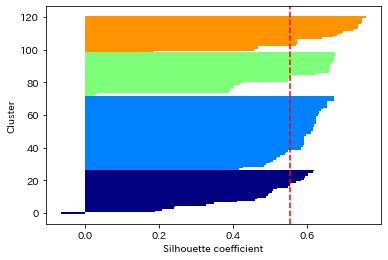

In [ ]:
#nを指定して、表示
km = KMeans(n_clusters=4,
            init='k-means++',     
            n_init=10,
            max_iter=300,
            random_state=0)

# クラスタ分類→[2, 1, 0, 2, 3, 0, 2, 1, 1, 3]
y_km = km.fit_predict(pref_silhhoette_XY)                         

# クラスタの重複をなくす→[0, 1, 2, 3]
cluster_labels = np.unique(y_km) 

# 配列の数：指定したクラスタ数→４
n_clusters = cluster_labels.shape[0] 

#シルエット係数を計算(引数：サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算)
silhouette_vals = silhouette_samples(pref_silhhoette_XY,y_km,metric='euclidean')

y_ax_lower, y_ax_upper = 0,0
yticks = []
for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    # サンプルの個数を足していく
    y_ax_upper +=len(c_silhouette_vals)
    # グラフ表示の色を作成
    color=cm.jet(float(i)/n_clusters)
    # 棒グラフを作成
    plt.barh(range(y_ax_lower,y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor='none',
        color=color
    )
    # クラスタラベルの表示位置
    yticks.append((y_ax_lower+y_ax_upper)/2.)
    # 底辺の値に棒の幅を足していく
    y_ax_lower += len(c_silhouette_vals)
    
#平均の位置に線を引く
silhouette_avg=np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")


In [ ]:
class_data_list = []
result_class_num = 0

# 2〜データ個数の9割りまでクラスタ数を指定する,今回は2-6で調べる
loop_num = 6 
for class_num in range(2, loop_num):
    # クラスタ分類
    km = KMeans(n_clusters=class_num,
            init='k-means++',     
            n_init=10,
            max_iter=300,
            random_state=0)
    y_km = km.fit_predict(pref_silhhoette_XY) 
    
    cluster_labels = np.unique(y_km) 

    # 配列の数
    n_clusters = cluster_labels.shape[0] 

    #シルエット係数を計算
    silhouette_vals = silhouette_samples(pref_silhhoette_XY,y_km,metric='euclidean')
    
    # クラスタ内のデータ数
    sil=[]
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals=silhouette_vals[y_km==c]
        sil.append(len(c_silhouette_vals))
    
    # クラスタ内のデータ数の差がデータ数の2割以下であれば分割できたとみなす
    data_diff = int(len(pref_silhhoette_XY.index) * 0.2)
    data_diff_flg = max(sil)-min(sil) < data_diff
    # クラスタ内のシルエット係数平均値
    ave_silhouette_vals = np.average(silhouette_vals)
    
    class_data_list.append({'class_num':class_num, 'data_diff':data_diff_flg, 'ave':ave_silhouette_vals})
    
        
max_ave = 0
for class_data in class_data_list:
    if class_data['data_diff'] and (max_ave < class_data['ave']):
        max_ave = class_data['ave']
        result_class_num = class_data['class_num']
        
print(result_class_num)



4


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

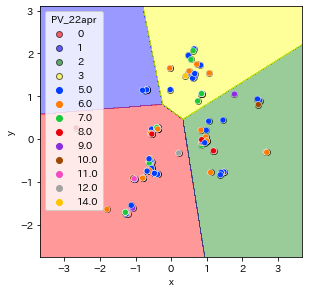

In [ ]:
# 決定境界プロット関数
def plot_decision_regions(x, y, model, resolution=0.01):

    ## 今回は被説明変数が3クラスのため散布図のマーカータイプと3種類の色を用意
    ## クラスの種類数に応じて拡張していくのが良いでしょう
    # markers = ('s', 'x', 'o')
    # cmap = ListedColormap(('red', 'blue', 'green'))
    markers = ('s', 'x', 'o', '^')
    cmap = ListedColormap(('red', 'blue', 'green','yellow'))

    ## 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    ## メッシュデータ全部を学習モデルで分類
    z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
    z = z.reshape(x1_mesh.shape)

    ## メッシュデータと分離クラスを使って決定境界を描いている
    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    #marker=markers[idx],
                    label=cl)

#
# データの取得
#
a = list(pref['x']/100)
b = list(pref['y']/100)
D = list()
for i in range(0,len(a)):
  d = np.array(list(zip(a,b))[i])
  D.append(d)
  E = np.array(D)

data = E
x_data = data.data
y_data = np.array(pref['cluster_label'])
#y_data = data.target


# 2変数だけを抽出
# x_data = x_data[:, [0,1]]

# 入力データの各変数が平均0,標準偏差1になるように正規化
# 各アルゴリズムのプロット結果を比較しやすいように予め全入力データを正規化
sc = StandardScaler()
sc.fit(x_data)
x_data = sc.transform(x_data)


# データを学習用/テスト用に分割している
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2)

#
# 機械学習アルゴリズムの定義
#
lr = LogisticRegression(C=10)
# knn = KNeighborsClassifier(n_neighbors=5)
# svm = SVC(kernel='rbf', C=1.0)
# dc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
# rf = RandomForestClassifier(criterion='entropy',
#                             n_estimators=10)

# models = [lr, knn, svm, dc, rf]
# model_names = ['logistic regression',
#                'k nearest neighbor',
#                'svm',
#                'decision tree',
#                'random forest']
models = [lr]
model_names = ['logistic regression']

#
# それぞれのモデルにおいて決定境界をプロット
#
# plt.figure(figsize=(8,6))
plt.figure(figsize=(8,4))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    # モデルの学習
    model.fit(x_train, y_train)
    # 決定境界をプロット
    plot_decision_regions(x_data, y_data, model)
    #plt.title(model_name)
    plot_num += 1

plt.tight_layout()
#plt.savefig('./images/decision_region.png')
sns.scatterplot(x='x', y='y', hue='PV_22apr',data = pref_22_5XYstd, palette='bright')
plt.show()

### 比較的実用的な実装

In [ ]:
state = input('都道府県(語尾に都道府県を付ける):')

都道府県(語尾に都道府県を付ける):愛知県


クラスター数は2です


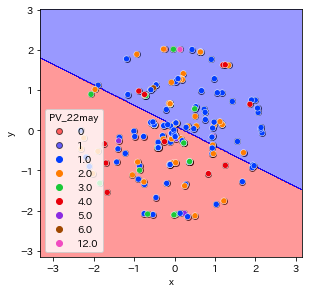

In [ ]:
#1つのカラムで、決定境界と散布図を表示できるように整える
#prefで、必要なデータがとってこれたとする。
matplotlib_axes_logger.setLevel('ERROR') #警告文の回避

pref = df_job.query('rc_pref == @state') 
pref_22_5 = pref #.query('5.0<=PV_22apr<=14.0') #10種類以下になるようにqueryする

pref_22_5_xy= pref_22_5[['x','y']]

scaler = StandardScaler()
scaler.fit(pref_22_5_xy)
scaler.transform(pref_22_5_xy)
pref_22_5_std = pd.DataFrame(scaler.transform(pref_22_5_xy), columns=pref_22_5_xy.columns)

pref_22_5 = pref_22_5.drop(['x','y'],axis = 1)
pref_22_5 = pref_22_5.reset_index()
pref_22_5XYstd = pd.concat([pref_22_5, pref_22_5_std], axis=1)

pref = pref_22_5XYstd

pref_silhhoette_XY = pref[['x','y']]

class_data_list = []
result_class_num = 0

# 2〜データ個数の9割りまでクラスタ数を指定する,今回は2-6で調べる
loop_num = 6 
for class_num in range(2, loop_num):
    # クラスタ分類
    km = KMeans(n_clusters=class_num,
            init='k-means++',     
            n_init=10,
            max_iter=300,
            random_state=0)
    y_km = km.fit_predict(pref_silhhoette_XY) 
    
    cluster_labels = np.unique(y_km) 

    # 配列の数
    n_clusters = cluster_labels.shape[0] 

    #シルエット係数を計算
    silhouette_vals = silhouette_samples(pref_silhhoette_XY,y_km,metric='euclidean')
    
    # クラスタ内のデータ数
    sil=[]
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals=silhouette_vals[y_km==c]
        sil.append(len(c_silhouette_vals))
    
    # クラスタ内のデータ数の差がデータ数の2割以下であれば分割できたとみなす
    data_diff = int(len(pref_silhhoette_XY.index) * 0.2)
    data_diff_flg = max(sil)-min(sil) < data_diff
    # クラスタ内のシルエット係数平均値
    ave_silhouette_vals = np.average(silhouette_vals)
    
    class_data_list.append({'class_num':class_num, 'data_diff':data_diff_flg, 'ave':ave_silhouette_vals})
    
        
max_ave = 0
for class_data in class_data_list:
    if class_data['data_diff'] and (max_ave < class_data['ave']):
        max_ave = class_data['ave']
        result_class_num = class_data['class_num']
        
print('クラスター数は{}です'.format(result_class_num))

#ラベルの取得
from sklearn.mixture import GaussianMixture
import time

num_clusters = result_class_num # 自分で適当な値に指定する

# Fit a Gaussian mixture with EM
# 各クラスタが等分散構造
clf =  GaussianMixture(n_components = num_clusters,
                       covariance_type = 'diag',
                       init_params = 'kmeans',
                       max_iter = 50,
                       random_state = 1)
# Get cluster assignments.
clf.fit(pref.loc[:,['x','y']])
label = clf.predict(pref.loc[:,['x','y']]) # 予測ラベル
#print(clf.bic(pref.loc[:,['x','y']]))
pref['cluster_label'] = label
pref['cluster_label'] = pref['cluster_label'].astype(str)

# 決定境界プロット関数
def plot_decision_regions(x, y, model, resolution=0.01):

    ## 今回は被説明変数が3クラスのため散布図のマーカータイプと3種類の色を用意
    ## クラスの種類数に応じて拡張していくのが良いでしょう
    # markers = ('s', 'x', 'o')
    # cmap = ListedColormap(('red', 'blue', 'green'))
    #クラスター数に対するマーカーの場合分け
    if result_class_num == 2:
      markers = ('s', 'x')
      cmap = ListedColormap(('red', 'blue'))
    if result_class_num == 3:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 4:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 4:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 5:
      markers = ('s', 'x', 'o', '^','m')
      cmap = ListedColormap(('red', 'blue', 'green','yellow','magenta'))
    if result_class_num == 5:
      markers = ('s', 'x', 'o', '^','m','c')
      cmap = ListedColormap(('red', 'blue', 'green','yellow','magenta',	'cyan'))

    ## 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    ## メッシュデータ全部を学習モデルで分類
    z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
    z = z.reshape(x1_mesh.shape)

    ## メッシュデータと分離クラスを使って決定境界を描いている
    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    #marker=markers[idx],
                    label=cl)

#
# データの取得
#
a = list(pref['x']/100)
b = list(pref['y']/100)
D = list()
for i in range(0,len(a)):
  d = np.array(list(zip(a,b))[i])
  D.append(d)
  E = np.array(D)

data = E
x_data = data.data
y_data = np.array(pref['cluster_label'])
#y_data = data.target


# 2変数だけを抽出
# x_data = x_data[:, [0,1]]

# 入力データの各変数が平均0,標準偏差1になるように正規化
# 各アルゴリズムのプロット結果を比較しやすいように予め全入力データを正規化
sc = StandardScaler()
sc.fit(x_data)
x_data = sc.transform(x_data)


# データを学習用/テスト用に分割している
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2)

#
# 機械学習アルゴリズムの定義
#
lr = LogisticRegression(C=10)
# knn = KNeighborsClassifier(n_neighbors=5)
# svm = SVC(kernel='rbf', C=1.0)
# dc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
# rf = RandomForestClassifier(criterion='entropy',
#                             n_estimators=10)

# models = [lr, knn, svm, dc, rf]
# model_names = ['logistic regression',
#                'k nearest neighbor',
#                'svm',
#                'decision tree',
#                'random forest']
models = [lr]
model_names = ['logistic regression']

#
# それぞれのモデルにおいて決定境界をプロット
#
# plt.figure(figsize=(8,6))
plt.figure(figsize=(8,4))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    # モデルの学習
    model.fit(x_train, y_train)
    # 決定境界をプロット
    plot_decision_regions(x_data, y_data, model)
    #plt.title(model_name)
    plot_num += 1

plt.tight_layout()
#plt.savefig('./images/decision_region.png')
sns.scatterplot(x='x', y='y', hue='PV_22may',data = pref_22_5XYstd,palette='bright')
plt.show()

クラスター数は2です


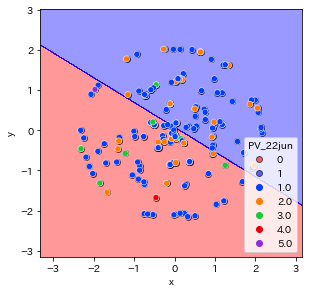

In [ ]:
#1つのカラムで、決定境界と散布図を表示できるように整える
#prefで、必要なデータがとってこれたとする。
matplotlib_axes_logger.setLevel('ERROR') #警告文の回避

pref = df_job.query('rc_pref == @state') 
pref_22_5 = pref #.query('5.0<=PV_22apr<=14.0') #10種類以下になるようにqueryする

pref_22_5_xy= pref_22_5[['x','y']]

scaler = StandardScaler()
scaler.fit(pref_22_5_xy)
scaler.transform(pref_22_5_xy)
pref_22_5_std = pd.DataFrame(scaler.transform(pref_22_5_xy), columns=pref_22_5_xy.columns)

pref_22_5 = pref_22_5.drop(['x','y'],axis = 1)
pref_22_5 = pref_22_5.reset_index()
pref_22_5XYstd = pd.concat([pref_22_5, pref_22_5_std], axis=1)

pref = pref_22_5XYstd

pref_silhhoette_XY = pref[['x','y']]

class_data_list = []
result_class_num = 0

# 2〜データ個数の9割りまでクラスタ数を指定する,今回は2-6で調べる
loop_num = 6 
for class_num in range(2, loop_num):
    # クラスタ分類
    km = KMeans(n_clusters=class_num,
            init='k-means++',     
            n_init=10,
            max_iter=300,
            random_state=0)
    y_km = km.fit_predict(pref_silhhoette_XY) 
    
    cluster_labels = np.unique(y_km) 

    # 配列の数
    n_clusters = cluster_labels.shape[0] 

    #シルエット係数を計算
    silhouette_vals = silhouette_samples(pref_silhhoette_XY,y_km,metric='euclidean')
    
    # クラスタ内のデータ数
    sil=[]
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals=silhouette_vals[y_km==c]
        sil.append(len(c_silhouette_vals))
    
    # クラスタ内のデータ数の差がデータ数の2割以下であれば分割できたとみなす
    data_diff = int(len(pref_silhhoette_XY.index) * 0.2)
    data_diff_flg = max(sil)-min(sil) < data_diff
    # クラスタ内のシルエット係数平均値
    ave_silhouette_vals = np.average(silhouette_vals)
    
    class_data_list.append({'class_num':class_num, 'data_diff':data_diff_flg, 'ave':ave_silhouette_vals})
    
        
max_ave = 0
for class_data in class_data_list:
    if class_data['data_diff'] and (max_ave < class_data['ave']):
        max_ave = class_data['ave']
        result_class_num = class_data['class_num']
        
print('クラスター数は{}です'.format(result_class_num))

#ラベルの取得
from sklearn.mixture import GaussianMixture
import time

num_clusters = result_class_num # 自分で適当な値に指定する

# Fit a Gaussian mixture with EM
# 各クラスタが等分散構造
clf =  GaussianMixture(n_components = num_clusters,
                       covariance_type = 'diag',
                       init_params = 'kmeans',
                       max_iter = 50,
                       random_state = 1)
# Get cluster assignments.
clf.fit(pref.loc[:,['x','y']])
label = clf.predict(pref.loc[:,['x','y']]) # 予測ラベル
#print(clf.bic(pref.loc[:,['x','y']]))
pref['cluster_label'] = label
pref['cluster_label'] = pref['cluster_label'].astype(str)

#ここまでで、クラスターラベルの取得

# 決定境界プロット関数
def plot_decision_regions(x, y, model, resolution=0.01):

    ## 今回は被説明変数が3クラスのため散布図のマーカータイプと3種類の色を用意
    ## クラスの種類数に応じて拡張していくのが良いでしょう
    # markers = ('s', 'x', 'o')
    # cmap = ListedColormap(('red', 'blue', 'green'))
    #クラスター数に対するマーカーの場合分け
    if result_class_num == 2:
      markers = ('s', 'x')
      cmap = ListedColormap(('red', 'blue'))
    if result_class_num == 3:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 4:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 4:
      markers = ('s', 'x', 'o', '^')
      cmap = ListedColormap(('red', 'blue', 'green','yellow'))
    if result_class_num == 5:
      markers = ('s', 'x', 'o', '^','m')
      cmap = ListedColormap(('red', 'blue', 'green','yellow','magenta'))
    if result_class_num == 5:
      markers = ('s', 'x', 'o', '^','m','c')
      cmap = ListedColormap(('red', 'blue', 'green','yellow','magenta',	'cyan'))

    ## 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
    x1_min, x1_max = x[:, 0].min()-1, x[:, 0].max()+1
    x2_min, x2_max = x[:, 1].min()-1, x[:, 1].max()+1
    x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                   np.arange(x2_min, x2_max, resolution))

    ## メッシュデータ全部を学習モデルで分類
    z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
    z = z.reshape(x1_mesh.shape)

    ## メッシュデータと分離クラスを使って決定境界を描いている
    plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
    plt.xlim(x1_mesh.min(), x1_mesh.max())
    plt.ylim(x2_mesh.min(), x2_mesh.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cl, 0],
                    y=x[y == cl, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolors='black',
                    #marker=markers[idx],
                    label=cl)

#
# データの取得
#
a = list(pref['x']/100)
b = list(pref['y']/100)
D = list()
for i in range(0,len(a)):
  d = np.array(list(zip(a,b))[i])
  D.append(d)
  E = np.array(D)

data = E
x_data = data.data
y_data = np.array(pref['cluster_label'])
#y_data = data.target


# 2変数だけを抽出
# x_data = x_data[:, [0,1]]

# 入力データの各変数が平均0,標準偏差1になるように正規化
# 各アルゴリズムのプロット結果を比較しやすいように予め全入力データを正規化
sc = StandardScaler()
sc.fit(x_data)
x_data = sc.transform(x_data)


# データを学習用/テスト用に分割している
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2)

#
# 機械学習アルゴリズムの定義
#
lr = LogisticRegression(C=10)
# knn = KNeighborsClassifier(n_neighbors=5)
# svm = SVC(kernel='rbf', C=1.0)
# dc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
# rf = RandomForestClassifier(criterion='entropy',
#                             n_estimators=10)

# models = [lr, knn, svm, dc, rf]
# model_names = ['logistic regression',
#                'k nearest neighbor',
#                'svm',
#                'decision tree',
#                'random forest']
models = [lr]
model_names = ['logistic regression']

#
# それぞれのモデルにおいて決定境界をプロット
#
# plt.figure(figsize=(8,6))
plt.figure(figsize=(8,4))
plot_num = 1
for model_name, model in zip(model_names, models):

    plt.subplot(math.ceil(len(models)/2), 2, plot_num)
    # モデルの学習
    model.fit(x_train, y_train)
    # 決定境界をプロット
    plot_decision_regions(x_data, y_data, model)
    #plt.title(model_name)
    plot_num += 1

plt.tight_layout()
#plt.savefig('./images/decision_region.png')
sns.scatterplot(x='x', y='y', hue='PV_22jun',data = pref_22_5XYstd,palette='bright')
plt.show()

### 単語間比較

In [ ]:
for i in range(0,result_class_num):
  a = str(i)
  pref_clas0 = pref[pref['cluster_label'] == a].reset_index()
  count1 = 0
  count2 = 0
  PV_22may_sw1 = 0
  PV_22jun_sw1 = 0
  PV_22may_sw2 = 0
  PV_22jun_sw2 = 0
  try:
    for i in range(0,len(pref_clas0)):
      if sw1 in pref_clas0['rc_jobtitile'][i]:
        PV_22may_sw1 += pref_clas0['PV_22may'][i]
        PV_22jun_sw1 += pref_clas0['PV_22jun'][i]
        count1+=1
      else:
        pass
      if sw2 in pref_clas0['rc_jobtitile'][i]:
        PV_22may_sw2 += pref_clas0['PV_22may'][i]
        PV_22jun_sw2 += pref_clas0['PV_22jun'][i]
        count2+=1
      else:
        pass
    dic_may = {sw1:PV_22may_sw1/count1,sw2:PV_22may_sw2/count2}
    dic_jun = {sw1:PV_22jun_sw1/count1,sw2:PV_22jun_sw2/count2}
    print('5月','クラスター',a,max(dic_may.keys()),max(dic_may.values()))
    print('6月','クラスター',a,max(dic_jun.keys()),max(dic_jun.values()))
  except:
    print('クラスター',a,'に',(sw1,sw2),'の単語ペアはありません')

5月 クラスター 0 保育士 1.9402985074626866
6月 クラスター 0 保育士 1.3880597014925373
5月 クラスター 1 保育士 2.0
6月 クラスター 1 保育士 1.3174603174603174


In [ ]:
sw1 = input('')
sw2 = input('')

保育
保育士


In [ ]:
for i in range(0,result_class_num):
  a = str(i)
  pref_clas0 = pref[pref['cluster_label'] == a].reset_index()
  count1 = 0
  count2 = 0
  CV_22may_sw1 = 0
  CV_22jun_sw1 = 0
  CV_22may_sw2 = 0
  CV_22jun_sw2 = 0
  try:
    for i in range(0,len(pref_clas0)):
      if sw1 in pref_clas0['rc_jobtitile'][i]:
        CV_22may_sw1 += pref_clas0['CV_22may'][i]
        CV_22jun_sw1 += pref_clas0['CV_22jun'][i]
        count1+=1
      else:
        pass
      if sw2 in pref_clas0['rc_jobtitile'][i]:
        CV_22may_sw2 += pref_clas0['CV_22may'][i]
        CV_22jun_sw2 += pref_clas0['CV_22jun'][i]
        count2+=1
      else:
        pass
    dic_may = {sw1:CV_22may_sw1/count1,sw2:CV_22may_sw2/count2}
    dic_jun = {sw1:CV_22jun_sw1/count1,sw2:CV_22jun_sw2/count2}
    print('5月','クラスター',a,max(dic_may.keys()),max(dic_may.values()))
    print('6月','クラスター',a,max(dic_jun.keys()),max(dic_jun.values()))
  except:
    print('クラスター',a,'に',(sw1,sw2),'の単語ペアはありません')

5月 クラスター 0 保育士 0.0
6月 クラスター 0 保育士 0.0
5月 クラスター 1 保育士 0.015873015873015872
6月 クラスター 1 保育士 0.0


In [ ]:
#PV調べ
pref_clas0 = pref[pref['cluster_label'] == str(0)].reset_index()
count1 = 0
count2 = 0
PV_22may_sw1 = 0
PV_22jun_sw1 = 0
PV_22may_sw2 = 0
PV_22jun_sw2 = 0
try:
  for i in range(0,len(pref_clas0)):
    if sw1 in pref_clas0['rc_jobtitile'][i]:
      PV_22may_sw1 += pref_clas0['PV_22may'][i]
      PV_22jun_sw1 += pref_clas0['PV_22jun'][i]
      count1+=1
    else:
      pass
    if sw2 in pref_clas0['rc_jobtitile'][i]:
      PV_22may_sw2 += pref_clas0['PV_22may'][i]
      PV_22jun_sw2 += pref_clas0['PV_22jun'][i]
      count2+=1
    else:
      pass
  dic_may = {sw1:PV_22may_sw1/count1,sw2:PV_22may_sw2/count2}
  dic_jun = {sw1:PV_22jun_sw1/count1,sw2:PV_22jun_sw2/count2}
  print(max(dic_may.keys()),max(dic_may.values()))
  print(max(dic_jun.keys()),max(dic_jun.values()))
except:
  print('その単語ペアはありません')
# print(PV_22may_sw1/count1,PV_22jun_sw1/count1)
# print(PV_22may_sw2/count2,PV_22jun_sw2/count2)
# dic_may = {sw1:PV_22may_sw1/count1,sw2:PV_22may_sw2/count2}
# dic_jun = {sw1:PV_22jun_sw1/count1,sw2:PV_22jun_sw2/count2}
# print(max(dic_may.keys()),max(dic_may.values()))
# print(max(dic_jun.keys()),max(dic_jun.values()))

保育士 1.9402985074626866
保育士 1.3880597014925373
